<a href="https://colab.research.google.com/github/SeeBook2022/SeeBook-OCR/blob/main/evaluate/iou_calculate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import shutil
import re

### xywh형태의 파일(yolo포맷의 라벨 데이터)을 xyxy로 바꿔주는 함수

In [24]:

def xywh_to_xyxy(file_path):
    result = []
    with open(file_path, 'r', encoding = 'utf-8-sig') as data_file:
        data = data_file.read()
        data = data.replace('\n','')
        data_list = data.split(' ')
        x1, x2 = float(data_list[1]) - float(data_list[3])/2, float(data_list[1]) + float(data_list[3])/2
        y1, y2 = float(data_list[2]) - float(data_list[4])/2, float(data_list[2]) + float(data_list[4])/2
        result.extend([round(x1,6), round(y1,6), round(x2,6), round(y2,6)])
    return result

### 0~1사이로 정규화 되어있는 값을 원래 값으로 바꿔주는 함수

In [25]:
 
def convert_to_ori_size(label_bbox, pred_bbox, image_shape):

    # label_bbox 변환 (0~1값 -> 원 사이즈)
    label_bbox[0] = int(label_bbox[0]*image_shape[1]) # x1좌표
    label_bbox[1] = int(label_bbox[1]*image_shape[0]) # y1좌표
    label_bbox[2] = int(label_bbox[2]*image_shape[1]) # x2좌표
    label_bbox[3] = int(label_bbox[3]*image_shape[0]) # y2좌표

    # pred_bbox 변환 (0~1값 -> 원 사이즈)
    pred_bbox[0] = int(pred_bbox[0]*image_shape[1]) # x1좌표
    pred_bbox[1] = int(pred_bbox[1]*image_shape[0]) # y1좌표
    pred_bbox[2] = int(pred_bbox[2]*image_shape[1]) # x2좌표
    pred_bbox[3] = int(pred_bbox[3]*image_shape[0]) # y2좌표

    return label_bbox, pred_bbox

### 이미지의 실제 bbox와 예측 bbox를 보여주는 함수

In [34]:

def show_bbox(file_path, label_bbox, pred_bbox):
    img = cv2.imread(file_path) 
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    label_ori, pred_ori =  convert_to_ori_size(label_bbox, pred_bbox, img.shape) # 0~1 사이의 bbox좌표를 원래 사이즈로 변환

    green = (0,255,0)
    red = (255,0,0)

    img_show = cv2.rectangle(img_rgb, (label_ori[0], label_ori[1]), (label_ori[2], label_ori[3]), color = green, thickness = 2) # label_bbox 표시 
    img_show = cv2.rectangle(img_rgb, (pred_ori[0], pred_ori[1]), (pred_ori[2], pred_ori[3]), color = red, thickness = 2) # pred_ori 표시
    
    plt.figure(figsize=(10,10))
    plt.imshow(img_show)
    plt.show()

### IoU 계산 함수

In [27]:

def cal_iou(label_box, pred_box):
    # coordinates of intersection area 
    x1 = np.maximum(pred_box[0], label_box[0])
    y1 = np.maximum(pred_box[1], label_box[1])
    x2 = np.minimum(pred_box[2], label_box[2])
    y2 = np.minimum(pred_box[3], label_box[3])

    # calculate intersection area
    inter = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

    # calculate bbox1, 2 area
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_box_area = (label_box[2] - label_box[0]) * (label_box[3] - label_box[1])

    # calculate union area
    union = pred_box_area + gt_box_area - inter

    # calculate iou
    iou = round(inter / union, 2)
    
    return iou

### jpg파일과 txt파일을 각각 image, labels 폴더로 이동

In [5]:
ori_dir = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/stage2_iou_test/test_label/'
labels_dir = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/stage2_iou_test/test_label/labels/'
images_dir = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/stage2_iou_test/test_label/images/'

file_names = os.listdir('/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/stage2_iou_test/test_label/')
file_names

for file_name in file_names:
    if '.txt' in file_name:
        shutil.move(ori_dir + file_name, labels_dir)
    elif '.jpg' in file_name:
        shutil.move(ori_dir + file_name, images_dir)
    else:
        continue


['images', 'labels']

### 파일이름을 오름차순으로 정렬하는 함수

In [6]:

def file_sorted(files):
    temp = [re.split(r"([0-9]+)", s) for s in files]
    sort = sorted(temp, key = lambda x: (x[0].lower(), int(x[1])))
    
    return [''.join(s) for s in sort]

### 파일경로를 리스트로 만드는 함수

In [7]:
def make_file_paths(path):
    img_names = os.listdir(path)
    file_names = file_sorted(img_names)
    file_paths = []
    for file_name in file_names:
        file_paths.append(path + file_name)

    return file_paths

### 정답 bbox와 예측 bbox의 IoU계산

In [29]:
# label bbox의 경로
labels_bbox_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/stage2_iou_test/test_label/labels/'
# predicted bbox의 경로
pred_bbox_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/stage2_iou_test/pred_bbox/labels/'

# label bbox, predicted bbox 파일들의 경로를 리스트로 저장
labels_list = make_file_paths(labels_bbox_path)
pred_list = make_file_paths(pred_bbox_path)

result = []

for labels in labels_list:
    label_name = labels.split('/')[-1] # label 데이터의 경로에서 파일 이름만 추출 

    for preds in pred_list:
        pred_name = preds.split('/')[-1] # predict 데이터의 경로에서 파일 이름만 추출
        if label_name == pred_name: # yolo의 결과값이 존재할 경우 iou 계산

            label_xyxy = xywh_to_xyxy(labels_bbox_path+label_name)
            pred_xyxy = xywh_to_xyxy(pred_bbox_path + label_name)

            calculated_iou = cal_iou(label_xyxy, pred_xyxy)
            result.append(label_name +' : '+ str(calculated_iou))

result



['test_crop_101.txt : 0.93',
 'test_crop_102.txt : 0.94',
 'test_crop_103.txt : 0.95',
 'test_crop_104.txt : 0.94',
 'test_crop_105.txt : 0.93',
 'test_crop_106.txt : 0.52',
 'test_crop_107.txt : 0.91',
 'test_crop_108.txt : 0.93',
 'test_crop_109.txt : 0.83',
 'test_crop_110.txt : 0.93',
 'test_crop_111.txt : 0.89',
 'test_crop_112.txt : 0.94',
 'test_crop_113.txt : 0.41',
 'test_crop_114.txt : 0.93',
 'test_crop_115.txt : 0.92',
 'test_crop_116.txt : 0.91',
 'test_crop_117.txt : 0.85',
 'test_crop_118.txt : 0.96',
 'test_crop_119.txt : 0.84',
 'test_crop_120.txt : 0.57',
 'test_crop_121.txt : 0.37',
 'test_crop_122.txt : 0.77',
 'test_crop_123.txt : 0.93',
 'test_crop_124.txt : 0.96',
 'test_crop_125.txt : 0.96',
 'test_crop_126.txt : 0.4',
 'test_crop_127.txt : 0.0',
 'test_crop_128.txt : 0.9',
 'test_crop_129.txt : 0.65',
 'test_crop_130.txt : 0.9',
 'test_crop_131.txt : 0.97',
 'test_crop_132.txt : 0.89',
 'test_crop_133.txt : 0.86',
 'test_crop_134.txt : 0.98',
 'test_crop_135.tx

### 결과확인

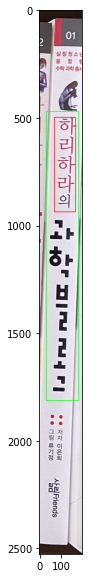

In [38]:
image_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/stage2_iou_test/test_label/images/'

bbox1 = xywh_to_xyxy(labels_bbox_path+'test_crop_144.txt') # labeled bbox : 초록색
bbox2 = xywh_to_xyxy(pred_bbox_path+'test_crop_144.txt') # predicted bbox : 빨간색

show_bbox(image_path+'test_crop_144.jpg', bbox1, bbox2)